In [2]:
import tensorflow as tf
import os
import glob
from models import dense_net as net
import numpy as np
import logging
import PARAMS
from dataset_factory.iwatch import process_image_convert_apply
from create_record_files import read_image
import tensorflow.contrib.slim as slim
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

### 1. create logger

In [3]:
file_logger = logging.getLogger('terminal-logger')
file_logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('test.md')
# 再创建一个handler，用于输出到控制台
ch = logging.StreamHandler()
file_logger.addHandler(fh)
file_logger.addHandler(ch)
dirs = os.listdir('shell_model/dense_net_k=12_ap/v1')
os.path.basename(os.listdir('shell_model/dense_net_k=12_ap/v1')[0])

'model_epoch274_1.0000.ckpt.data-00000-of-00001'

### 2.define parameters

In [4]:
test_index = 5
params = PARAMS.Params()
class_nums = params.params['model']['classNum']
resize_height = 224 # 指定存储图片高度
resize_width = 224  # 指定存储图片宽度
labels_filename='dataset/label.txt'
batch_size = 1  #
depths = 3
tensorBoard_path = params.params['path']['test_tensorBoardPath']
# TODO CHANGE MODEL PATH AND MODEL NAME
root_dir1 = 'dataset/dataset/{0}_of_5folds/val_aumentation'.format(test_index)
root_dir2 = 'dataset/dataset/{0}_of_5folds/val'.format(test_index)
output_graph = 'shell_model/dense_net.pb'
models_path = 'shell_model/dense_net_k12_k0.9/v{0}'.format(test_index)  #查看checkPoint的名称即可
models_path = os.path.join\
                (models_path, os.path.basename(os.listdir(models_path)[0])).strip('.data-00000-of-00001')+'t'
image_dirs_va = [os.path.join(root_dir1, sub_dir) for sub_dir in os.listdir(root_dir1)]
image_dirs_v =  [os.path.join(root_dir2, sub_dir) for sub_dir in os.listdir(root_dir2)]
print(image_dirs_v)
print(image_dirs_va)
print(models_path)

['dataset/dataset/5_of_5folds/val\\NG', 'dataset/dataset/5_of_5folds/val\\OK']
['dataset/dataset/5_of_5folds/val_aumentation\\NG', 'dataset/dataset/5_of_5folds/val_aumentation\\OK']
shell_model/dense_net_k12_k0.9/v5\model_epoch294_0.9857.ckpt


### 3. define propagate graph
- define label dictionary
- define input
- define net

In [5]:
labels = np.loadtxt(labels_filename, str, delimiter='\t')
with tf.name_scope("inputs"):
    input_images = tf.placeholder(dtype=tf.float32, shape=[None, resize_height, resize_width, depths],
                                  name='inputs')  # 由于图像存储的原因，灰度图维度较少一维
with tf.name_scope("net"):
    out,endPoints = net.inference(inputs=input_images, num_classes=class_nums, dropout_keep_prob=1.0,
                        is_training=False)
with tf.name_scope("feature_map"):
    feture_maps = endPoints["layer1"]
    # 取其中的第一张图像
    # TODO 第一层输出的feauture值可能会不一样
    # TODO ix，iy为宽度和高度
    # TODO cx cy为每行显示的图像 ix*iy=channels
    feture_maps = tf.slice(feture_maps, (0, 0, 0, 0), (1, -1, -1, -1))
    ix = iy = 28
    ix += 4
    iy += 4
    #类似subplot的方法图像显示为4x4
    cy = 4
    cx = 3
    #做padding方便将所有图分开
    feture_maps = tf.image.resize_image_with_crop_or_pad(feture_maps, iy, ix)
    # reshape 成 56x56x4x4
    feture_maps = tf.reshape(feture_maps, (iy, ix, cy, cx))
    #交换维度
    feture_maps = tf.transpose(feture_maps, (2, 0, 3, 1))  # cy,iy,cx
    #将所有通道的图片组成一张图片显示
    feture_maps = tf.reshape(feture_maps, (1, cy * iy, cx * ix, 1))
    tf.summary.image("dense_block1", feture_maps, 1)
# 将输出结果进行softmax分布,再求最大概率所属类别
with tf.name_scope('Output'):
    score = tf.nn.softmax(out,name='predict')
    class_id = tf.argmax(score, 1)
summary_merge = tf.summary.merge_all()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.flatten instead.


### 4. define predict

In [6]:
def predict(image_dirs, is_savePb = True):
    error_list = []
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    tensorboard_writer = tf.summary.FileWriter(tensorBoard_path, sess.graph)
    saver = tf.train.Saver()
    saver.restore(sess, models_path)
    step = 0
    for image_dir in image_dirs:
#         images_list=glob.glob(os.path.join(image_dir,'*.png'))
        images_list = [os.path.join(image_dir, file) for file in os.listdir(image_dir)]
        for i in range(len(images_list)):
            #tf 读取图片
    #         image_string = tf.read_file(images_list[i])
    #         image_decoded = tf.image.decode_bmp(image_string, channels=1)  # (1)
            ori_image= Image.open(images_list[i],'r')
#             print(images_list[i])
            image = tf.cast(ori_image, tf.float32)
            input_image = process_image_convert_apply(image,is_training=False)
            input_image = tf.expand_dims(input_image,0)
            img_real = sess.run(input_image)
            summary,pre_score,pre_index = sess.run([summary_merge,score,class_id], feed_dict={input_images:img_real})
            max_score=pre_score[0,pre_index]
            g_label= os.path.basename(os.path.dirname(images_list[i]))
            pre_label = str(labels[pre_index][0])
            if  pre_label != g_label:
                tensorboard_writer.add_summary(summary,step)
                print(g_label + 'predict is: ' + pre_label + ' score is' + str(max_score))
                error_list.append(images_list[i])          
                plt.figure()
                plt.title('label is {0}, pre is {1}'.format(g_label,pre_label)) 
                imshow(ori_image)
            step = step + 1
    tensorboard_writer.close()
    if is_savePb:
        ##存成pbfile, 注意必须为List才能存
        outPut_nodeName = []
        outPut_nodeName.append('Output/predict')
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,  # The session is used to retrieve the weights
            tf.get_default_graph().as_graph_def(),  # The graph_def is used to retrieve the nodes
            output_node_names=outPut_nodeName  # The output node names are used to select the usefull nodes
        )

        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
    sess.close()
    return error_list

In [7]:
 errorlist1 = predict(image_dirs_v ,False)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from shell_model/dense_net_k12_k0.9/v5\model_epoch294_0.9857.ckpt


In [8]:
print(errorlist1)

[]


INFO:tensorflow:Restoring parameters from shell_model/dense_net_k12_k0.9/v5\model_epoch294_0.9857.ckpt
NGpredict is: OK score is[0.90111923]
NGpredict is: OK score is[0.72235185]


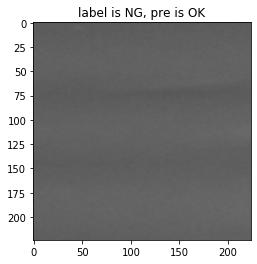

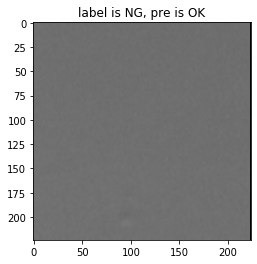

In [9]:
errorlist2 = predict(image_dirs_va ,False)

In [10]:
print(errorlist2)
print(len(errorlist2))

['dataset/dataset/5_of_5folds/val_aumentation\\NG\\crop_33.bmp', 'dataset/dataset/5_of_5folds/val_aumentation\\NG\\deformH_29.bmp']
2
